
Import packages
----------------

In [1]:
!pip install --upgrade albumentations
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install torchsummary

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
%cd /content/drive/MyDrive/
import model

/content/drive/MyDrive


In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

import albumentations as A

from torchsummary import summary

from tqdm import tqdm


Device type
----------------

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if use_cuda:
  torch.cuda.manual_seed(SEED)
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

Load and Prepare dataset
----------------

In [4]:
'''Before any image transformations'''

simple_transforms = transforms.Compose([transforms.ToTensor(), # Automatically converts it between 0-1. ?
                                      #  transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])
exp = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=simple_transforms)
exp_loader = torch.utils.data.DataLoader(exp, batch_size=16,
                                          shuffle=True, num_workers=2)

# avg(std(minibatch_1) + std(minibatch_2) + .. ) != std(dataset). Need to check further
mean = 0.
std = 0.
for images, _ in exp_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!) ; images of torch.Size([16, 3, 32, 32])
    images = images.view(batch_samples, images.size(1), -1) # ; images of torch.Size([16, 3, 1024])
    mean += images.mean(2).sum(0) # Mean is calculated image-channel, and [16,3]. It is then summed across the images for each channel, and [3]
    std += images.std(2).sum(0)

mean /= len(exp_loader.dataset) # This gives number of total images
std /= len(exp_loader.dataset)

print (f'mean: {mean}')
print (f'std: {std}')

Files already downloaded and verified
mean: tensor([0.4914, 0.4822, 0.4465])
std: tensor([0.2023, 0.1994, 0.2010])


horse :   car :   car :  deer :  ship : plane : horse :  bird : plane :   dog :  ship :  bird :   car :  deer :   car :   car


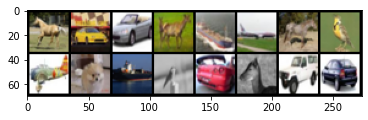

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    # print (img.shape) # [3, 70, 274]
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # (3, 70, 274)
    temp=np.transpose(npimg, (1, 2, 0))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (70, 274, 3)


# get some random training images
dataiter = iter(exp_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' : '.join('%5s' % classes[labels[j]] for j in range(16)))

In [6]:
'''simple image transformations'''

# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                        ])

# train = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms) 

# dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=16)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'simple image transformations'

In [7]:
'''image transformations'''

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

# custom dataset class for albumentations library. Normalize, and then perform augmentions? or reverse?
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list):
      self.image_list = image_list
      self.aug = A.Compose({
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.5, 0.5, 0.5],mask_fill_value=None, always_apply=False, p=0.5),
      A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), always_apply=False, p=1.0),
      })
        
  def __len__(self):
      return (len(self.image_list))
  
  def __getitem__(self, i):

      image = self.image_list[i][0]
      label = self.image_list[i][1]

      image = self.aug(image=np.array(image))['image'] # send as numpy array
      # print (image.shape)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      # print (image.shape)
          
      return torch.tensor(image, dtype=torch.float), label

train = torchvision.datasets.CIFAR10('./data', train=True, download=True)
test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms) 

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=16)

# train dataloader
train_dataset = AlbumentationImageDataset(train)
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Defining the model
----------------

In [8]:
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x3 --- 3x3x16 --- 32x32x16, RF : 3x3
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x16 --- 3x3x16 --- 32x32x16, RF : 5x5
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),     

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x16 --- 3x3x16 --- 32x32x16, RF : 7x7
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1), 
        ) 
        
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x16 --- MP --- 16x16x16, RF : 14x14 (Old calculation)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, padding=0, bias=False), # 16x16x16 --- 1x1x32 --- 16x16x32, RF : 14x14. ReLU, BN, Dropout?
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 3x3x32 --- 16x16x32, RF : 16x16
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 3x3x32 --- 16x16x32, RF : 18x18
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),     

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 33x3x32 --- 16x16x32, RF : 20x20
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1), 
        ) 

        self.transblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16x32 --- MP --- 8x8x32, RF : 40x40 (Old calculation)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, padding=0, bias=False), # 8x8x32 --- 1x1x64 --- 8x8x64, RF : 40x40. ReLU, BN, Dropout?
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, bias=False), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 42x42
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, bias=False), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 44x44
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),     

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, bias=False), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 46x46
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1), 
        ) 

        self.transblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8x64 --- MP --- 4x4x64, RF : 92x92 (Old calculation)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, bias=False), # 4x4x64 --- 1x1x128 --- 4x4x128, RF : 92x92. ReLU, BN, Dropout?
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False), # 4x4x128 --- 3x3x128 --- 4x4x128, RF : 94x94
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1),

            nn.AvgPool2d(4), # 4x4x128 --- GAP --- 1x1x128, RF : 94x94

            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1, padding=0, bias=False), # 1x1x128 --- 1x1x10 --- 1x1x10, RF : 94x94

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.transblock2(x)
        x = self.convblock3(x)
        x = self.transblock3(x)
        x = self.convblock4(x)
        x = x.reshape(-1, 10)
        return F.log_softmax(x, dim=-1)'''

In [9]:
'''
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin, bias=False)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x3 --- 3x3x16 --- 32x32x16, RF : 3x3
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.01),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x16 --- 3x3x16 --- 32x32x16, RF : 5x5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.01),     

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 32x32x16 --- 3x3x16 --- 32x32x16, RF : 7x7
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.01), 
    ) 

    self.transblock1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, padding=0, stride=2, bias=False), # 32x32x16 --- MP --- 16x16x16, RF : 14x14 (Old calculation)
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.01),

        # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, padding=0, bias=False), # 16x16x16 --- 1x1x32 --- 16x16x32, RF : 14x14. ReLU, BN, Dropout?
    ) 

    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 3x3x32 --- 16x16x32, RF : 16x16
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(0.01),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 3x3x32 --- 16x16x32, RF : 18x18
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(0.01),     

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # 16x16x32 --- 33x3x32 --- 16x16x32, RF : 20x20
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(0.01), 
    ) 

    self.transblock2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, padding=0, stride=2, bias=False), # 16x16x32 --- MP --- 8x8x32, RF : 40x40 (Old calculation)

        # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, padding=0, bias=False), # 8x8x32 --- 1x1x64 --- 8x8x64, RF : 40x40. ReLU, BN, Dropout?
    )

    self.convblock3 = nn.Sequential(
        depthwise_separable_conv(32, 64), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 42x42
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(0.01),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, dilation=2, bias=False), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 44x44
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(0.01),     

        # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0, bias=False), # 8x8x64 --- 3x3x64 --- 8x8x64, RF : 46x46
        # nn.ReLU(),
        # nn.BatchNorm2d(64),
        # nn.Dropout(0.01), 
    ) 
    '''
    self.transblock3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, padding=0, stride=2, bias=False), # 8x8x64 --- MP --- 4x4x64, RF : 92x92 (Old calculation)

        # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, bias=False), # 4x4x64 --- 1x1x128 --- 4x4x128, RF : 92x92. ReLU, BN, Dropout?
    )

    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False), # 4x4x128 --- 3x3x128 --- 4x4x128, RF : 94x94
        nn.ReLU(),
        # nn.BatchNorm2d(16),
        # nn.Dropout(0.1),

        nn.AvgPool2d(4), # 4x4x128 --- GAP --- 1x1x128, RF : 94x94

        nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1, padding=0, bias=False), # 1x1x128 --- 1x1x10 --- 1x1x10, RF : 94x94

    ) '''

    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1, padding=0, bias=False), # 1x1x128 --- 1x1x10 --- 1x1x10, RF : 94x94

            nn.AvgPool2d(4),
    )

  def forward(self, x):
      x = self.convblock1(x)
      x = self.transblock1(x)
      x = self.convblock2(x)
      x = self.transblock2(x)
      x = self.convblock3(x)
      # x = self.transblock3(x)
      x = self.convblock4(x)
      x = x.reshape(-1, 10)
      return F.log_softmax(x, dim=-1)'''

Model Summary
----------------

In [10]:
model = model.Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 16, 16]           1,024
             ReLU-14           [-1, 16,

Train and Test Functions
----------------

In [11]:
def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  epoch_loss = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()

    pred = y_pred.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  return epoch_loss / len(train_loader), 100*correct/processed

def test(model, device, test_loader):
  model.eval()

  correct = 0
  test_loss = 0

  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() 
      pred = output.argmax(dim=1, keepdim=True)  
      correct += pred.eq(target.view_as(pred)).sum().item() 

  test_loss /= len(test_loader.dataset) # Should this be changed to len(test_loader) ?

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  
  return test_loss, 100. * correct / len(test_loader.dataset)


Train the model
-----------------

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epoch+1):
    print('Epoch:',epoch)

    train_loss, train_acc  = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.2606877088546753 Batch_id=781 Accuracy=39.48: 100%|██████████| 782/782 [00:18<00:00, 42.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3759, Accuracy: 5077/10000 (51%)

Epoch: 2


Loss=1.161672592163086 Batch_id=781 Accuracy=49.33: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1347, Accuracy: 5975/10000 (60%)

Epoch: 3


Loss=1.7876131534576416 Batch_id=781 Accuracy=54.42: 100%|██████████| 782/782 [00:18<00:00, 41.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0431, Accuracy: 6387/10000 (64%)

Epoch: 4


Loss=1.0483026504516602 Batch_id=781 Accuracy=57.63: 100%|██████████| 782/782 [00:18<00:00, 42.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9573, Accuracy: 6560/10000 (66%)

Epoch: 5


Loss=1.066549301147461 Batch_id=781 Accuracy=60.32: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8516, Accuracy: 6961/10000 (70%)

Epoch: 6


Loss=1.1722708940505981 Batch_id=781 Accuracy=62.21: 100%|██████████| 782/782 [00:18<00:00, 41.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8067, Accuracy: 7127/10000 (71%)

Epoch: 7


Loss=1.4307243824005127 Batch_id=781 Accuracy=63.44: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7773, Accuracy: 7272/10000 (73%)

Epoch: 8


Loss=1.7181817293167114 Batch_id=781 Accuracy=65.08: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7545, Accuracy: 7377/10000 (74%)

Epoch: 9


Loss=1.2867517471313477 Batch_id=781 Accuracy=65.83: 100%|██████████| 782/782 [00:18<00:00, 41.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7451, Accuracy: 7367/10000 (74%)

Epoch: 10


Loss=1.114356279373169 Batch_id=781 Accuracy=66.90: 100%|██████████| 782/782 [00:18<00:00, 41.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6927, Accuracy: 7549/10000 (75%)

Epoch: 11


Loss=0.8428760766983032 Batch_id=781 Accuracy=67.66: 100%|██████████| 782/782 [00:18<00:00, 42.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6813, Accuracy: 7611/10000 (76%)

Epoch: 12


Loss=0.6374810338020325 Batch_id=781 Accuracy=68.18: 100%|██████████| 782/782 [00:18<00:00, 42.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6611, Accuracy: 7696/10000 (77%)

Epoch: 13


Loss=1.1641852855682373 Batch_id=781 Accuracy=68.76: 100%|██████████| 782/782 [00:18<00:00, 41.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6697, Accuracy: 7661/10000 (77%)

Epoch: 14


Loss=0.7343208193778992 Batch_id=781 Accuracy=69.17: 100%|██████████| 782/782 [00:18<00:00, 42.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6497, Accuracy: 7746/10000 (77%)

Epoch: 15


Loss=2.012012243270874 Batch_id=781 Accuracy=69.85: 100%|██████████| 782/782 [00:18<00:00, 42.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6398, Accuracy: 7836/10000 (78%)

Epoch: 16


Loss=0.9485390782356262 Batch_id=781 Accuracy=70.35: 100%|██████████| 782/782 [00:18<00:00, 41.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6185, Accuracy: 7881/10000 (79%)

Epoch: 17


Loss=1.0395419597625732 Batch_id=781 Accuracy=70.82: 100%|██████████| 782/782 [00:18<00:00, 41.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6060, Accuracy: 7954/10000 (80%)

Epoch: 18


Loss=0.5291470289230347 Batch_id=781 Accuracy=70.80: 100%|██████████| 782/782 [00:18<00:00, 42.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6038, Accuracy: 7918/10000 (79%)

Epoch: 19


Loss=0.9685276746749878 Batch_id=781 Accuracy=71.36: 100%|██████████| 782/782 [00:18<00:00, 41.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5941, Accuracy: 7951/10000 (80%)

Epoch: 20


Loss=1.4263899326324463 Batch_id=781 Accuracy=71.79: 100%|██████████| 782/782 [00:18<00:00, 41.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5898, Accuracy: 7988/10000 (80%)

Epoch: 21


Loss=1.3582674264907837 Batch_id=781 Accuracy=71.59: 100%|██████████| 782/782 [00:18<00:00, 41.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5972, Accuracy: 7964/10000 (80%)

Epoch: 22


Loss=0.3601420521736145 Batch_id=781 Accuracy=72.46: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5745, Accuracy: 8061/10000 (81%)

Epoch: 23


Loss=1.3902316093444824 Batch_id=781 Accuracy=72.63: 100%|██████████| 782/782 [00:18<00:00, 42.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5792, Accuracy: 8008/10000 (80%)

Epoch: 24


Loss=0.9603317379951477 Batch_id=781 Accuracy=72.90: 100%|██████████| 782/782 [00:19<00:00, 40.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5634, Accuracy: 8045/10000 (80%)

Epoch: 25


Loss=0.6067687273025513 Batch_id=781 Accuracy=73.34: 100%|██████████| 782/782 [00:18<00:00, 41.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5479, Accuracy: 8156/10000 (82%)

Epoch: 26


Loss=0.7102828025817871 Batch_id=781 Accuracy=73.05: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5449, Accuracy: 8098/10000 (81%)

Epoch: 27


Loss=1.1607425212860107 Batch_id=781 Accuracy=73.36: 100%|██████████| 782/782 [00:18<00:00, 41.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5530, Accuracy: 8065/10000 (81%)

Epoch: 28


Loss=1.1430283784866333 Batch_id=781 Accuracy=73.95: 100%|██████████| 782/782 [00:18<00:00, 41.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5447, Accuracy: 8151/10000 (82%)

Epoch: 29


Loss=0.6919323801994324 Batch_id=781 Accuracy=73.74: 100%|██████████| 782/782 [00:18<00:00, 41.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5260, Accuracy: 8168/10000 (82%)

Epoch: 30


Loss=0.8805546760559082 Batch_id=781 Accuracy=74.30: 100%|██████████| 782/782 [00:18<00:00, 41.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5213, Accuracy: 8204/10000 (82%)

Epoch: 31


Loss=0.2534288763999939 Batch_id=781 Accuracy=74.21: 100%|██████████| 782/782 [00:18<00:00, 41.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5166, Accuracy: 8212/10000 (82%)

Epoch: 32


Loss=0.5237772464752197 Batch_id=781 Accuracy=74.44: 100%|██████████| 782/782 [00:18<00:00, 41.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 8210/10000 (82%)

Epoch: 33


Loss=0.3946118950843811 Batch_id=781 Accuracy=74.54: 100%|██████████| 782/782 [00:18<00:00, 41.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5152, Accuracy: 8243/10000 (82%)

Epoch: 34


Loss=0.6599379777908325 Batch_id=781 Accuracy=74.98: 100%|██████████| 782/782 [00:18<00:00, 41.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5195, Accuracy: 8199/10000 (82%)

Epoch: 35


Loss=0.5108648538589478 Batch_id=781 Accuracy=74.99: 100%|██████████| 782/782 [00:18<00:00, 41.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4953, Accuracy: 8289/10000 (83%)

Epoch: 36


Loss=0.7100592255592346 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:18<00:00, 41.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5027, Accuracy: 8256/10000 (83%)

Epoch: 37


Loss=0.48309749364852905 Batch_id=781 Accuracy=74.82: 100%|██████████| 782/782 [00:18<00:00, 41.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5125, Accuracy: 8252/10000 (83%)

Epoch: 38


Loss=0.8837501406669617 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:19<00:00, 41.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4969, Accuracy: 8266/10000 (83%)

Epoch: 39


Loss=0.768663763999939 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [00:18<00:00, 41.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4956, Accuracy: 8277/10000 (83%)

Epoch: 40


Loss=1.002925157546997 Batch_id=781 Accuracy=75.23: 100%|██████████| 782/782 [00:19<00:00, 41.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4988, Accuracy: 8282/10000 (83%)

Epoch: 41


Loss=0.5054243206977844 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:19<00:00, 41.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4830, Accuracy: 8329/10000 (83%)

Epoch: 42


Loss=0.5376115441322327 Batch_id=781 Accuracy=75.87: 100%|██████████| 782/782 [00:19<00:00, 41.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4798, Accuracy: 8347/10000 (83%)

Epoch: 43


Loss=0.8940845131874084 Batch_id=781 Accuracy=76.01: 100%|██████████| 782/782 [00:19<00:00, 41.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4779, Accuracy: 8330/10000 (83%)

Epoch: 44


Loss=0.47314006090164185 Batch_id=781 Accuracy=75.75: 100%|██████████| 782/782 [00:19<00:00, 41.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8349/10000 (83%)

Epoch: 45


Loss=0.6149790287017822 Batch_id=781 Accuracy=76.19: 100%|██████████| 782/782 [00:18<00:00, 41.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4718, Accuracy: 8368/10000 (84%)

Epoch: 46


Loss=0.7026861310005188 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:18<00:00, 41.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4734, Accuracy: 8391/10000 (84%)

Epoch: 47


Loss=1.0475455522537231 Batch_id=781 Accuracy=76.14: 100%|██████████| 782/782 [00:19<00:00, 40.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4778, Accuracy: 8358/10000 (84%)

Epoch: 48


Loss=0.5403318405151367 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:18<00:00, 41.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4717, Accuracy: 8384/10000 (84%)

Epoch: 49


Loss=1.0924955606460571 Batch_id=781 Accuracy=76.50: 100%|██████████| 782/782 [00:19<00:00, 40.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4701, Accuracy: 8361/10000 (84%)

Epoch: 50


Loss=0.8912194967269897 Batch_id=781 Accuracy=76.43: 100%|██████████| 782/782 [00:18<00:00, 41.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4822, Accuracy: 8361/10000 (84%)

Epoch: 51


Loss=0.7428035140037537 Batch_id=781 Accuracy=76.69: 100%|██████████| 782/782 [00:19<00:00, 40.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4692, Accuracy: 8382/10000 (84%)

Epoch: 52


Loss=0.924680769443512 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [00:19<00:00, 40.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4697, Accuracy: 8390/10000 (84%)

Epoch: 53


Loss=0.6734523773193359 Batch_id=781 Accuracy=77.01: 100%|██████████| 782/782 [00:19<00:00, 40.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4552, Accuracy: 8435/10000 (84%)

Epoch: 54


Loss=0.24359536170959473 Batch_id=781 Accuracy=77.07: 100%|██████████| 782/782 [00:19<00:00, 40.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 8439/10000 (84%)

Epoch: 55


Loss=0.5637433528900146 Batch_id=781 Accuracy=76.84: 100%|██████████| 782/782 [00:19<00:00, 40.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4604, Accuracy: 8393/10000 (84%)

Epoch: 56


Loss=0.9755420684814453 Batch_id=781 Accuracy=76.92: 100%|██████████| 782/782 [00:19<00:00, 41.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4589, Accuracy: 8419/10000 (84%)

Epoch: 57


Loss=0.792567253112793 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:19<00:00, 40.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4585, Accuracy: 8427/10000 (84%)

Epoch: 58


Loss=0.7931519746780396 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:19<00:00, 40.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4619, Accuracy: 8393/10000 (84%)

Epoch: 59


Loss=0.755946695804596 Batch_id=781 Accuracy=77.45: 100%|██████████| 782/782 [00:19<00:00, 40.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8436/10000 (84%)

Epoch: 60


Loss=0.8197323679924011 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:19<00:00, 40.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4545, Accuracy: 8417/10000 (84%)

Epoch: 61


Loss=0.8531884551048279 Batch_id=781 Accuracy=77.73: 100%|██████████| 782/782 [00:19<00:00, 40.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4463, Accuracy: 8460/10000 (85%)

Epoch: 62


Loss=0.5450985431671143 Batch_id=781 Accuracy=77.38: 100%|██████████| 782/782 [00:19<00:00, 40.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4444, Accuracy: 8440/10000 (84%)

Epoch: 63


Loss=0.7506168484687805 Batch_id=781 Accuracy=77.59: 100%|██████████| 782/782 [00:19<00:00, 40.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4464, Accuracy: 8483/10000 (85%)

Epoch: 64


Loss=0.3538845479488373 Batch_id=781 Accuracy=77.86: 100%|██████████| 782/782 [00:19<00:00, 40.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4558, Accuracy: 8461/10000 (85%)

Epoch: 65


Loss=1.1370902061462402 Batch_id=781 Accuracy=77.64: 100%|██████████| 782/782 [00:19<00:00, 40.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4605, Accuracy: 8432/10000 (84%)

Epoch: 66


Loss=0.552440881729126 Batch_id=781 Accuracy=78.05: 100%|██████████| 782/782 [00:19<00:00, 39.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4438, Accuracy: 8494/10000 (85%)

Epoch: 67


Loss=0.9224295020103455 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [00:19<00:00, 40.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4465, Accuracy: 8479/10000 (85%)

Epoch: 68


Loss=0.782529354095459 Batch_id=781 Accuracy=78.01: 100%|██████████| 782/782 [00:19<00:00, 40.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4441, Accuracy: 8479/10000 (85%)

Epoch: 69


Loss=0.8232539892196655 Batch_id=781 Accuracy=78.19: 100%|██████████| 782/782 [00:19<00:00, 40.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4445, Accuracy: 8471/10000 (85%)

Epoch: 70


Loss=0.402693510055542 Batch_id=781 Accuracy=78.33: 100%|██████████| 782/782 [00:19<00:00, 40.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4440, Accuracy: 8468/10000 (85%)

Epoch: 71


Loss=1.505517601966858 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [00:19<00:00, 40.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4331, Accuracy: 8543/10000 (85%)

Epoch: 72


Loss=0.42857784032821655 Batch_id=781 Accuracy=78.36: 100%|██████████| 782/782 [00:19<00:00, 40.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4381, Accuracy: 8534/10000 (85%)

Epoch: 73


Loss=0.6086395978927612 Batch_id=781 Accuracy=78.35: 100%|██████████| 782/782 [00:19<00:00, 40.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4364, Accuracy: 8505/10000 (85%)

Epoch: 74


Loss=0.2357768714427948 Batch_id=781 Accuracy=78.32: 100%|██████████| 782/782 [00:19<00:00, 40.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4405, Accuracy: 8489/10000 (85%)

Epoch: 75


Loss=1.4447169303894043 Batch_id=781 Accuracy=78.56: 100%|██████████| 782/782 [00:19<00:00, 40.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4289, Accuracy: 8532/10000 (85%)

Epoch: 76


Loss=0.6197686791419983 Batch_id=781 Accuracy=78.59: 100%|██████████| 782/782 [00:19<00:00, 40.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4331, Accuracy: 8519/10000 (85%)

Epoch: 77


Loss=0.49291127920150757 Batch_id=781 Accuracy=78.84: 100%|██████████| 782/782 [00:19<00:00, 40.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4367, Accuracy: 8492/10000 (85%)

Epoch: 78


Loss=0.4548797905445099 Batch_id=781 Accuracy=78.83: 100%|██████████| 782/782 [00:19<00:00, 39.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4276, Accuracy: 8515/10000 (85%)

Epoch: 79


Loss=0.7496145367622375 Batch_id=781 Accuracy=78.59: 100%|██████████| 782/782 [00:19<00:00, 40.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4309, Accuracy: 8537/10000 (85%)

Epoch: 80


Loss=0.6977660059928894 Batch_id=781 Accuracy=78.65: 100%|██████████| 782/782 [00:19<00:00, 40.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4303, Accuracy: 8513/10000 (85%)

Epoch: 81


Loss=0.6251769065856934 Batch_id=781 Accuracy=78.53: 100%|██████████| 782/782 [00:19<00:00, 40.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4259, Accuracy: 8568/10000 (86%)

Epoch: 82


Loss=0.3814528286457062 Batch_id=781 Accuracy=78.68: 100%|██████████| 782/782 [00:19<00:00, 40.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4273, Accuracy: 8540/10000 (85%)

Epoch: 83


Loss=0.8741500377655029 Batch_id=781 Accuracy=78.71: 100%|██████████| 782/782 [00:19<00:00, 39.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4263, Accuracy: 8524/10000 (85%)

Epoch: 84


Loss=0.9993168115615845 Batch_id=781 Accuracy=78.73: 100%|██████████| 782/782 [00:19<00:00, 40.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4226, Accuracy: 8556/10000 (86%)

Epoch: 85


Loss=0.5677241086959839 Batch_id=781 Accuracy=78.74: 100%|██████████| 782/782 [00:19<00:00, 39.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Accuracy: 8570/10000 (86%)

Epoch: 86


Loss=1.3861863613128662 Batch_id=781 Accuracy=78.96: 100%|██████████| 782/782 [00:19<00:00, 39.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4317, Accuracy: 8527/10000 (85%)

Epoch: 87


Loss=0.32318082451820374 Batch_id=781 Accuracy=79.04: 100%|██████████| 782/782 [00:19<00:00, 40.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4321, Accuracy: 8526/10000 (85%)

Epoch: 88


Loss=0.6984806060791016 Batch_id=781 Accuracy=78.97: 100%|██████████| 782/782 [00:19<00:00, 39.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4166, Accuracy: 8585/10000 (86%)

Epoch: 89


Loss=0.6636987924575806 Batch_id=781 Accuracy=78.96: 100%|██████████| 782/782 [00:19<00:00, 39.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4146, Accuracy: 8581/10000 (86%)

Epoch: 90


Loss=0.7295807600021362 Batch_id=781 Accuracy=79.13: 100%|██████████| 782/782 [00:19<00:00, 40.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4260, Accuracy: 8535/10000 (85%)

Epoch: 91


Loss=0.6589689254760742 Batch_id=781 Accuracy=79.06: 100%|██████████| 782/782 [00:19<00:00, 40.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4137, Accuracy: 8608/10000 (86%)

Epoch: 92


Loss=0.6612673401832581 Batch_id=781 Accuracy=79.26: 100%|██████████| 782/782 [00:19<00:00, 39.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4119, Accuracy: 8638/10000 (86%)

Epoch: 93


Loss=0.5731875896453857 Batch_id=781 Accuracy=79.49: 100%|██████████| 782/782 [00:19<00:00, 40.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4092, Accuracy: 8617/10000 (86%)

Epoch: 94


Loss=1.6776431798934937 Batch_id=781 Accuracy=79.58: 100%|██████████| 782/782 [00:19<00:00, 39.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4166, Accuracy: 8589/10000 (86%)

Epoch: 95


Loss=0.6058226227760315 Batch_id=781 Accuracy=79.87: 100%|██████████| 782/782 [00:19<00:00, 39.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4151, Accuracy: 8571/10000 (86%)

Epoch: 96


Loss=0.5978845357894897 Batch_id=781 Accuracy=79.36: 100%|██████████| 782/782 [00:19<00:00, 39.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4074, Accuracy: 8618/10000 (86%)

Epoch: 97


Loss=0.5926452875137329 Batch_id=781 Accuracy=78.97: 100%|██████████| 782/782 [00:19<00:00, 39.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4224, Accuracy: 8568/10000 (86%)

Epoch: 98


Loss=0.3167649507522583 Batch_id=781 Accuracy=79.45: 100%|██████████| 782/782 [00:19<00:00, 39.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Accuracy: 8561/10000 (86%)

Epoch: 99


Loss=0.5024046897888184 Batch_id=781 Accuracy=79.67: 100%|██████████| 782/782 [00:19<00:00, 39.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4187, Accuracy: 8591/10000 (86%)

Epoch: 100


Loss=0.2952866852283478 Batch_id=781 Accuracy=79.40: 100%|██████████| 782/782 [00:19<00:00, 39.30it/s]



Test set: Average loss: 0.4111, Accuracy: 8575/10000 (86%)



Model Evaluation
-------------------------

Text(0.5, 1.0, 'Test Accuracy')

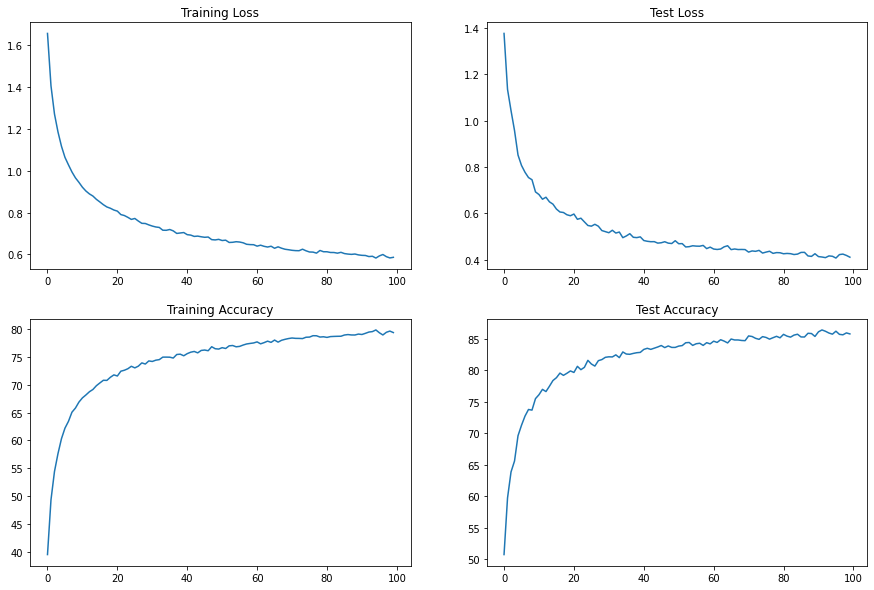

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")

Misclassified Images
-----------------------------